Resources
* https://kidquant.com/project/401k-optimization-using-modern-portfolio-theory/
    * https://github.com/KidQuant/401K-Optimization-Using-Modern-Portfolio-Theory/blob/master/401K%20Optimization%20Using%20Modern%20Portfolio%20Theory.ipynb
* https://github.com/otosman/Python-for-Finance/blob/master/Portfolio%20Optimization%20401k.ipynb
* https://towardsdatascience.com/best-investment-portfolio-via-monte-carlo-simulation-in-python-53286f3fe93
* https://medium.com/@ajit.gopalakrishnan/optimizing-your-401-k-portfolio-using-python-bde6457e7e1b
* https://www.google.com/search?q=401k+portfolio+optimizer+python&rlz=1C1ASVC_enUS1020US1020&oq=401k+portfolio+optimizer+python&aqs=chrome..69i57.5597j0j1&sourceid=chrome&ie=UTF-8

Github
* https://github.com/ksun0/401k-optimizer
* https://hackbox.microsoft.com/rules#basic-rules

401k facts
* Microsoft 25 funds
* some companies have self-directed 401k
* max out post-tax/roth 401k
* https://wealth45.com/microsoft-401k-plan/

# 401(k)
401(k)s are defined contribution plans where employees employees and employers (with a certain level of matching) to an investment account. At Microsoft, which uses Fidelity to manage 401(k), employees are faced with various options, such as the kind of 401(k) they want to contribute to, what percentage of their salary paychecks they want to contribute (up to the IRS limit), and perhaps most crucially, their specific investment elections. These investment elections could be controlled automatically by Fidelity using their recommendations, or self-elected from a pre-determined small pool of stock and bond mutual fonds.

Most people in the workforce contribute a large fraction of their paychecks to their 401(k), some of which also get a large percentage of employer matching. As a result, a large volume of money sits in accounts, potentially safe from tax, but not all of them are growing as much as they could. Even though 401(k) has limited selection of funds, the right allocation can greatly increase growth. 401(k) Portfolio Optimizer can recommend the most optimal allocation of stocks, bonds, and other funds for any individual, given their preferences and parameters, when they make they enroll in 401(k), and make their initial allocations. A web visualizer can also help people track their investments over time, and potentially alter their allocations year by year to get the most of their 401(k) money. 

![title](401k_investment_elections.png)

Let's start with some EDA. We will use Yahoo Finance API to extract the historic asset prices of the funds.

In [79]:
import pandas as pd
import numpy as np
import fix_yahoo_finance as yf
import matplotlib.pyplot as plt
import scipy.optimize as sco
from sklearn.preprocessing import StandardScaler


import seaborn as sns; sns.set(style="whitegrid")
np.random.seed(42)

In [11]:
import datetime
from dateutil.relativedelta import relativedelta

end = datetime.date(2022,8,31)
beg = end - relativedelta(years = 10)

In [38]:
# Setting the tickers and extracting the historical price data

blended_ticks = ["LINIX", "LIKIX", "STLFX", "LIZKX", "LIRIX", "LIBIX", "LIJIX", "LIVIX", "LIHIX", "LIWIX", "PIRMX", "PAUAX"] # blended fund investments
# BTC LPATH IDX 2030 N, 2040, 2050, 2060, RET, 2025, 2035, 2055, 2045, 2065, PIM INFL RESP MA IS, PIM ALL A ALL AUTH I
large_ticks1 = ["VRGWX", "VRVIX", "VSPVX"] # stock investments: large cap
# VANG RUS 1000 GR TR, 1000 VAL TR, VAN IS S&P500 IDX TR
large_ticks2 = ["FCNTX", "FDGRX"] # stock investments: large cap
# FID CONTRA POOL CL 3, FID GR CO POOL CL 3
mid_ticks =["ARTMX"] # stock investments: mid
# ARTISAN MID CAP
small_ticks1 =["VRTGX"] # stock investments: small
# VANG RUS 2000 GR TR
small_ticks2 =["SEVAX"] # stock investments: small
# SMID CAP VALUE ACCT
international_ticks = ["FIVLX", "FIGFX"] # stock investments: international
# INTL VALUE ACCOUNT, INTL GROWTH ACCOUNT
short_ticks = ["BTCFX"] # short term investments
# BTC SHRT-TERM INV
bond_ticks = ["PTTRX", "VBIPX"] # bond investments: income
# PIMCO TOAL RETURN, VANG ST BD IDX IS PL

blended_df = pd.DataFrame(yf.download(blended_ticks, start=beg, end=end)['Adj Close'])
large_df1 = pd.DataFrame(yf.download(large_ticks1, start=beg, end=end)['Adj Close'])
large_df2 = pd.DataFrame(yf.download(large_ticks2, start=beg, end=end)['Adj Close'])
mid_df = pd.DataFrame(yf.download(mid_ticks, start=beg, end=end)['Adj Close'])
small_df1 = pd.DataFrame(yf.download(small_ticks1, start=beg, end=end)['Adj Close'])
small_df2 = pd.DataFrame(yf.download(small_ticks2, start=beg, end=end)['Adj Close'])
international_df = pd.DataFrame(yf.download(international_ticks, start=beg, end=end)['Adj Close'])
short_df = pd.DataFrame(yf.download(short_ticks, start=beg, end=end)['Adj Close'])
bond_df = pd.DataFrame(yf.download(bond_ticks, start=beg, end=end)['Adj Close'])

[*********************100%***********************]  12 of 12 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  2 of 2 completed


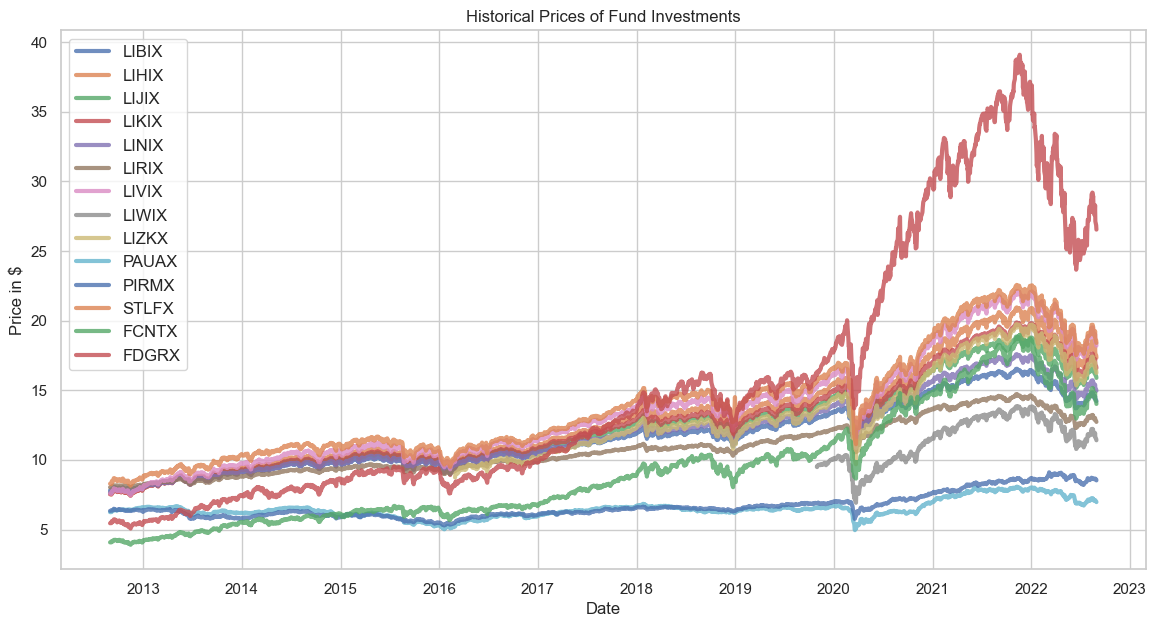

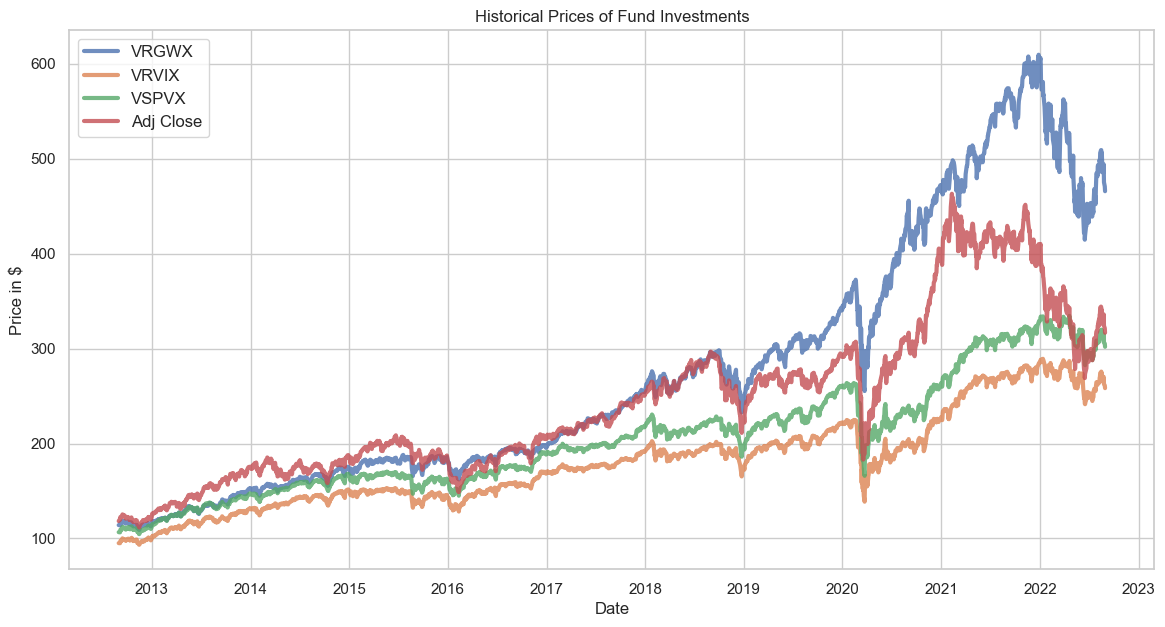

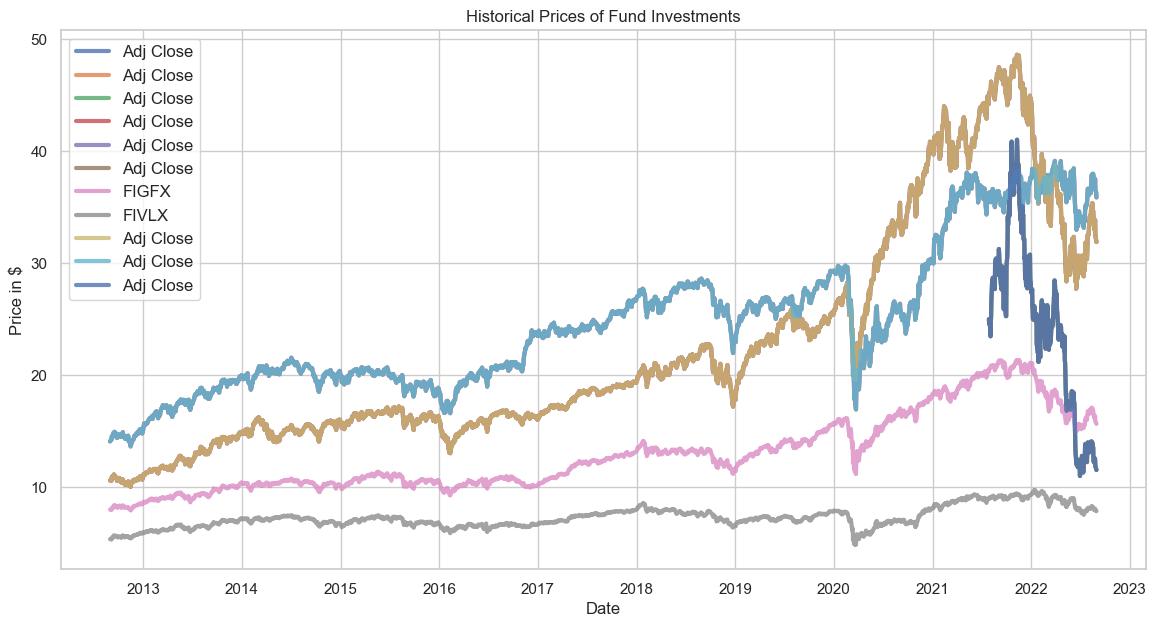

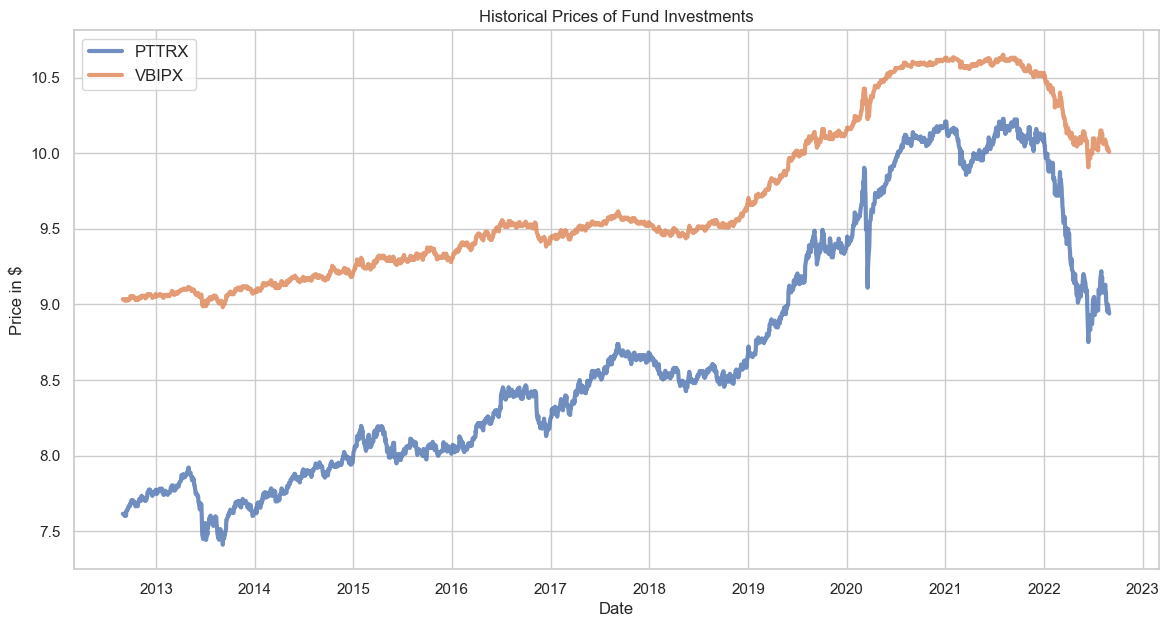

In [39]:
def generate_asset_plot(asset_dfs):
    df = pd.concat(asset_dfs, axis=1)
    plt.figure(figsize=(14, 7))
    for c in df.columns.values:
        plt.plot(df.index, df[c], lw=3, alpha=0.8,label=c)
    plt.legend(loc='upper left', fontsize=12)
    plt.ylabel('Price in $')
    plt.xlabel('Date')
    plt.title('Historical Prices of Fund Investments')

generate_asset_plot([blended_df, large_df2])
generate_asset_plot([large_df1, small_df1])
generate_asset_plot([mid_df, small_df2, international_df, short_df])
generate_asset_plot([bond_df])

We split up the different types of funds (large-cap, mid-cap, small-cap, international equities, blended, fixed income, etc.) beacuse they have different magnitude of asset prices.

It seems that a lot of these funds track each other, so we can filter some of them.

In [72]:
all_dfs = [blended_df, large_df1, large_df2, mid_df, small_df1, small_df2, international_df, short_df, bond_df]
blended_ticks = ["STLFX", "LIRIX", "LIBIX", "LIHIX"] # PIRMX and PAUAX track each other, etc.
large_ticks1 = ["VRGWX", "VRVIX"] # VRVIX and VSPVX track each other
international_ticks = ["FIGFX"] # FIVLX and FIGFX track each other
all_ticks = blended_ticks + large_ticks1 + large_ticks2 + mid_ticks + small_ticks1 + small_ticks2 + international_ticks + short_ticks + bond_ticks
beg = end - relativedelta(years = 5)
all_df = pd.DataFrame(yf.download(all_ticks, start=beg, end=end)['Adj Close'])

[*********************100%***********************]  15 of 15 completed


Certain mutual funds have grown a lot in value, with up to ~20% annual returns over a 5-10 year period. It is still a question of whether or not we should allocate the majority of our contribution amount into the fund with best annual return.

We can also standard scale the funds so that we can visualize them all in one graph.

In [73]:
#lets calc returns and cov matrix
rets = np.log(1+all_df.pct_change()).dropna()
mean_rets = rets.mean()*252
cov = rets.cov()*252
syms = len(all_ticks)

<Figure size 2000x1000 with 0 Axes>

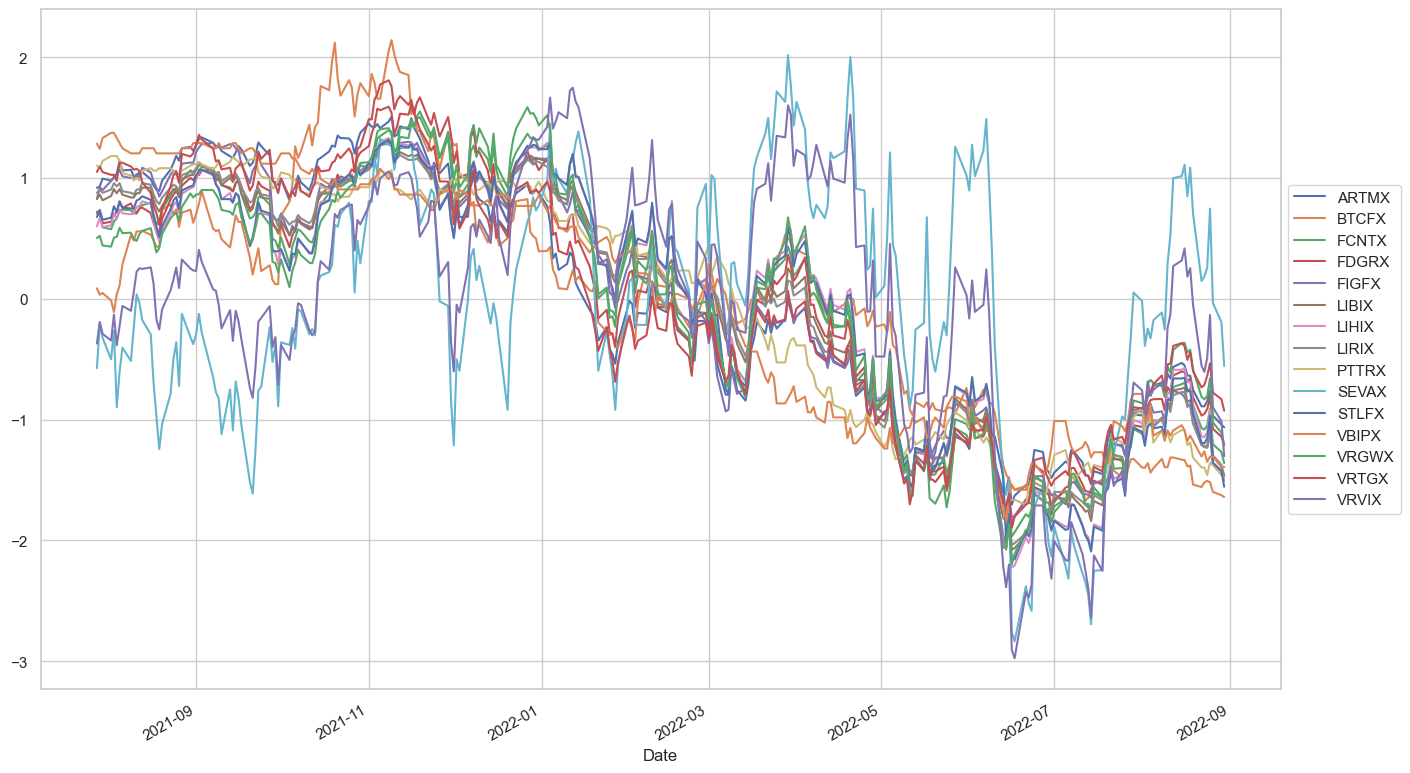

In [74]:
scaler = StandardScaler()
all_dfNA =all_df.dropna()
values = scaler.fit_transform(all_dfNA.values)
data_std = pd.DataFrame(values,index=all_dfNA.index, columns=all_dfNA.columns)

f = plt.figure(figsize = (20,10))
data_std.plot(figsize= (16,10))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

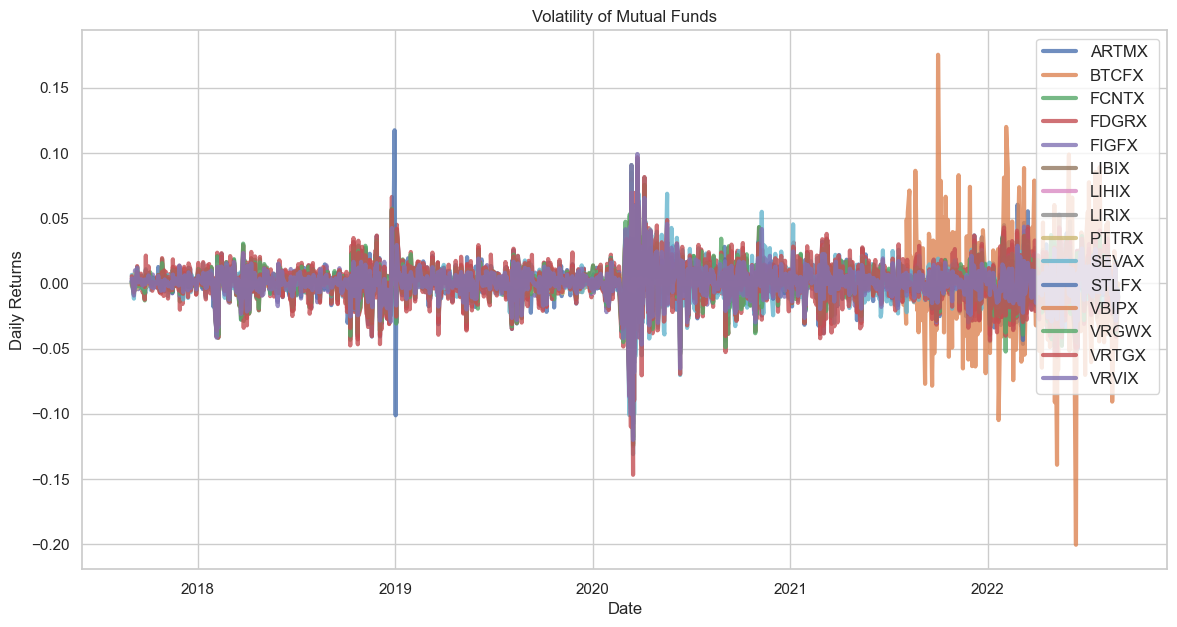

In [75]:
def generate_asset_volatility_plot(asset_dfs):
    df = pd.concat(asset_dfs, axis=1)

    returns = df.pct_change()

    plt.figure(figsize=(14,7))
    for c in returns.columns.values:
        plt.plot(returns.index, returns[c], lw=3, alpha=0.8, label=c)
    plt.legend(loc='upper right', fontsize=12)
    plt.ylabel('Daily Returns')
    plt.xlabel('Date')
    plt.title('Volatility of Mutual Funds')
    
generate_asset_volatility_plot([all_df])

Certain stocks have more volatility, which means that they can have a high positive magnitude of returns or negative. From this graph, BTCFX makes sense, since it is called "Bitcoin Strategy ProFund Investor Class" and has exposure to crypto/Bitcoin.

# Modern Portfolio Theory (MPT)
MPT conceptualizes how investors construct portfolios that maximize their expected for retuns for a given level of risk. MPT assumes that investors arae risk-averse, meaning that given two portfolios that have the same expected return, investors will prefer the less risky portfolio. However, investors who wants higher expected returns must accept more risk, which creates a trade-off, depending on invdividual risk preferences.

In [76]:
def portfolio_annualized_performance(weights, mean_returns, cov_matrix):
    
    # Calculates portfolio returns with the assigned number of weights
    returns = np.sum(mean_returns*weights ) *252
    # Calculates the portfolio standard deviation with the number of weights and the 
    # calculated covariance of each portfolio pair
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    # returns the portfolio standard deviation and portfolio returns
    return std, returns

#Generates portfolios with random weights assigned to each stock

# Creates a function that takes four arguments: number of portfolioes, average asset returns
# covariance of asset pairs and the risk free rate

def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    
    # Creates an array, which will hold three parameters: standard deviations, returns, sharpe ratio
    results = np.zeros((3,num_portfolios))
    
    # Creates an empty list called 'weights_record'
    weights_record = []
    
    # loops the following for the number of portfolios
    for i in range(num_portfolios):
        
        # Creates a random weight for each mutual fund, sums them, then appends them to 'weights_record'
        weights = np.random.random(len(all_ticks))
        weights /= np.sum(weights)
        weights_record.append(weights)
        
        # unpackages the returned results of 'portfolio_annualized_performance' funciton, then assigns the result
        # to list called 'results'
        portfolio_std_dev, portfolio_return = portfolio_annualized_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        
        # calculates the sharpe ratio from the previous results
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

returns = all_df.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 5000000
# The 10-Year Treasury Note can be considered a proxy for the risk-free rate. At the time of writing this, the yield on the 10-Year Treasury is 3.10%.
risk_free_rate = 0.031078 

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualized Return: 0.11
Annualized Volatility: 0.17


            ARTMX  BTCFX  FCNTX  FDGRX  FIGFX  LIBIX  LIHIX  LIRIX  PTTRX  \
allocation    5.0   0.09  18.11  17.49   1.51   0.98   0.84  13.13  10.87   

            SEVAX  STLFX  VBIPX  VRGWX  VRTGX  VRVIX  
allocation   1.69   4.09    3.6  18.06   1.45    3.1  
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualized Return: 0.05
Annualized Volatility: 0.09


            ARTMX  BTCFX  FCNTX  FDGRX  FIGFX  LIBIX  LIHIX  LIRIX  PTTRX  \
allocation   1.16   0.41   3.45   2.39   5.61  18.51   5.81   6.37  15.62   

            SEVAX  STLFX  VBIPX  VRGWX  VRTGX  VRVIX  
allocation   1.39   4.28  25.26   4.08   2.86   2.81  


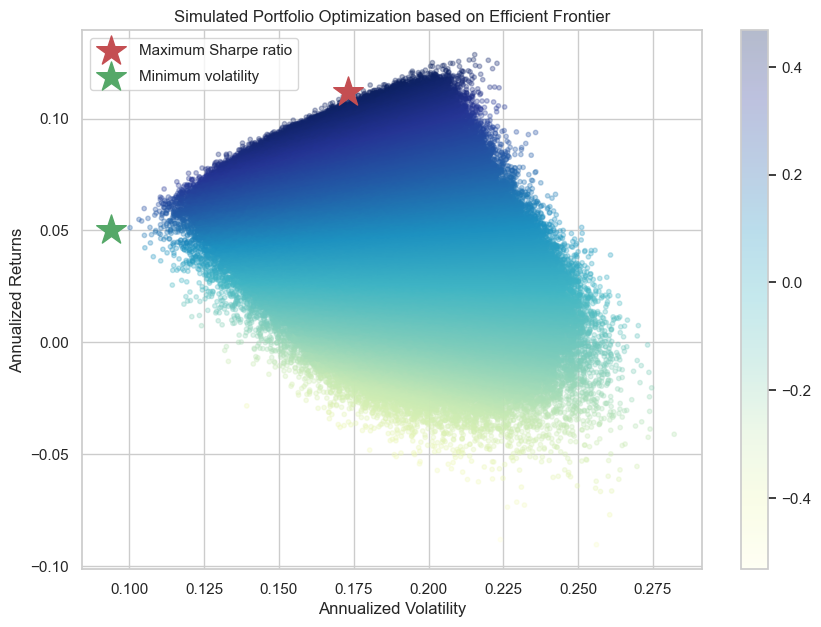

In [77]:
# create a function that takes four arguments

def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    
    # unpacks the results of the 'random_portfolios' function into the 'results' and 'weights' variables
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    # takes the largest sharpe ratio from the results array and assigns it to 'max_sharpe_idx'
    max_sharpe_idx = np.argmax(results[2])
    
    # assigns the portfolio standard deviation and return to std and rp
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    
    # creates a new dataframe of different portfolio weights with the maximum sharpe ratio
    # assigns a random allocation for each portfolio weight
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=all_df.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    # creates a new dataframe of different portfolio weights with the minimum volatility ratio
    # assigns a random allocation for each portfolio weight
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=all_df.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    # Uses the parameters above to locate the highest sharpe ratio and displays it with a red star sign
    # Does the same with the minimum volatility portfolio, and displays it with a green star on the plot
    print( "-"*80)
    print( "Maximum Sharpe Ratio Portfolio Allocation\n")
    print( "Annualized Return:", round(rp,2))
    print( "Annualized Volatility:", round(sdp,2))
    print( "\n")
    print( max_sharpe_allocation)
    print( "-"*80)
    print( "Minimum Volatility Portfolio Allocation\n")
    print( "Annualized Return:", round(rp_min,2))
    print( "Annualized Volatility:", round(sdp_min,2))
    print( "\n")
    print( min_vol_allocation)

    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('Annualized Volatility')
    plt.ylabel('Annualized Returns')
    plt.legend(labelspacing=0.8)
    
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

Efficient frontier: points are randomly selected simulated portfolios, the arch line on the top of he clustered blue dots is called the efficient frontier. Line points give lowest risk for a given target return. All other dots to the right or below the line will offer same returns for more risk or less returns for the same amount of risk.

The two points are minimum risk or maximum risk-adjusted return.

Why do different potfolios give diff expected return? Diversification. Returns of potfolios are greatly affected by the nature of the relationship between assets and their weights in the portfolio. E.g. risk is reduced by holding financial assets that do not positively correlate, aka reducing exposure to an individual asset by holding a diversified portfolio of assets.

![title](efficient_frontier.jpg)

# Sharpe Ratio
It measures the performance of an investment compared to a risk-free asset, adjustinf for its risk. The risk-free rate is the hypotehetical returns with no risk of financial loss over a specific period of time, which is improtant to compare to becasue investors could jsut invest in the risk-free asset to generate certain but lower returns. The 10-year treasury note is a proxy for risk-free rate, with a yield of 3.10%.

To calucalte the best portfolios with 2 given matrics rather tha simulating random chocies and picking the best ones, we use scipy's optimize function to determine the maximum sharpe ratio portoflio.

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualized Return: 0.19
Annualized Volatility: 0.26


            ARTMX  BTCFX  FCNTX  FDGRX  FIGFX  LIBIX  LIHIX  LIRIX  PTTRX  \
allocation    0.0    0.0    0.0  100.0    0.0    0.0    0.0    0.0    0.0   

            SEVAX  STLFX  VBIPX  VRGWX  VRTGX  VRVIX  
allocation    0.0    0.0    0.0    0.0    0.0    0.0  
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation
Annualized Return: 0.01
Annualized Volatility 0.02


       allocation
ARTMX        0.00
BTCFX        0.00
FCNTX        0.00
FDGRX        0.00
FIGFX        0.00
LIBIX        0.00
LIHIX        0.00
LIRIX        0.00
PTTRX        0.00
SEVAX        0.00
STLFX        0.00
VBIPX       97.59
VRGWX        0.00
VRTGX        0.00
VRVIX        2.41


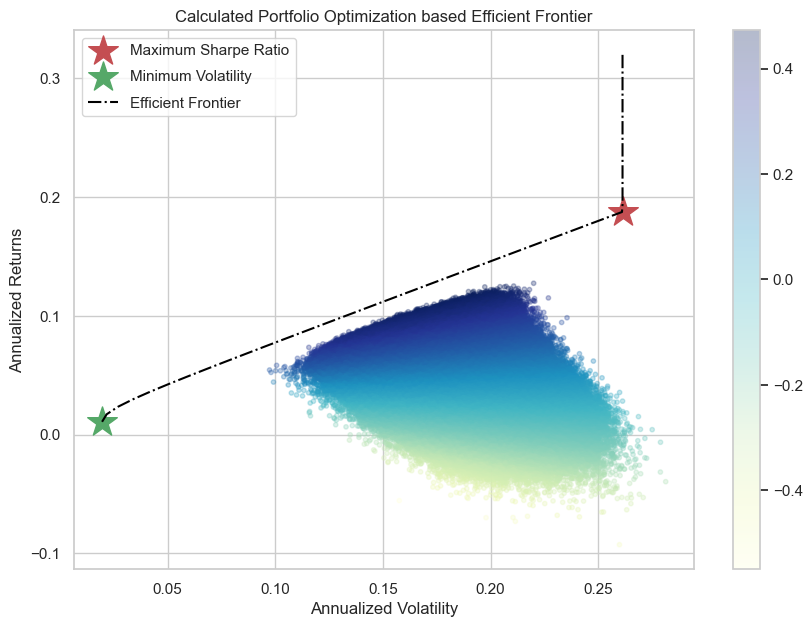

In [78]:
# Creating a function for the negative sharpe ratio. Has similiar parameters, with the exception that the results are negative
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualized_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

# Defines a function that takes three arguments
def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    
    # takes the number of assets and assigns to variable "num_assets"
    num_assets = len(mean_returns)
    
    # takes the arguments from the function and assigns to variable "args"
    args = (mean_returns, cov_matrix, risk_free_rate)
    
    # this variable will be read by our scipy minimize function, which basically states that the sum of x should equal 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    
    # bounds determine the limit assigned by random weights, stating that each weight should be between 0 and 1 inclusively
    bound = (0.0,1.0)
    
    # creates tuple of bounds for each of our 5 assets
    bounds = tuple(bound for asset in range(num_assets))
    
    # finds the maximum sharpe ratio and assigns the value to a variable called "result"
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

# provides the annualized volatility, which is first value of the returned index
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualized_performance(weights, mean_returns, cov_matrix)[0]

# creates a function with two arguments
def min_variance(mean_returns, cov_matrix):
    
    # takes the number of assets and assigns to variable "num_assets"
    num_assets = len(mean_returns)
    
    # takes the two arguments and assigns them to the variable "args"
    args = (mean_returns, cov_matrix)
    
    # this variable will be read by our scipy minimize function, which basically states that the sum of x should equal 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    
    # bounds determine the limit assigned by random weights, stating that each weight should be between 0 and 1 inclusively
    bound = (0.0,1.0)
    
    # creates tuple of bounds for each of our 5 assets
    bounds = tuple(bound for asset in range(num_assets))
    
    # finds the maximum sharpe ratio and assigns the value to a variable called "result"
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

# creates a function that takes three arguments
def efficient_return(mean_returns, cov_matrix, target):
    
    # takes the number of each asset and assigns to a variable called "num_assets"
    num_assets = len(mean_returns)
    
    # assigns the arguments of the function to a variable called "args"
    args = (mean_returns, cov_matrix)
    
    # calls the "portfolio_return" function and returns only portfolio_returns
    def portfolio_return(weights):
        return portfolio_annualized_performance(weights, mean_returns, cov_matrix)[1]
    
    # establishes our contrains for the efficient portfolio line
    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', 
                          bounds=bounds, constraints=constraints)
    return result

# creates a function that takes three arguments
def efficient_frontier(mean_returns, cov_matrix, returns_range):

    # creates an empty list called "efficients"
    efficients = []
    
    # creates a for loop that calculates the efficient return and appends them to the empty list "efficients" 
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

# Creates a function that takes four arguments
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    
    # puts the results in the "random_portfolios" function. Extracts the results in a variable called "results"
    results, _ = random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate)

    # takes three of the arguments in a function called "max_sharpe_ratio". 
    # Assigns the results in a variable called "max_sharpe"
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)

    # takes the "max_sharpe" variable and puts it in the "portfolio_annualized_performance". 
    # unpackages the results in two variables
    sdp, rp = portfolio_annualized_performance(max_sharpe['x'], mean_returns, cov_matrix)
    
    # creates a new dataframe of different portfolio weights with the maximum sharpe ratio
    # assigns a random allocation for each portfolio weight
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x, index=all_df.columns, columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100, 2) for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    # creates a new dataframe of different portfolio weights with the minimum volatility ratio
    # assigns a random allocation for each portfolio weight
    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualized_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x, index=all_df.columns, columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2) for i in min_vol_allocation.allocation]

    print( '-'*80)
    print( 'Maximum Sharpe Ratio Portfolio Allocation\n')
    print( 'Annualized Return:', round(rp,2))
    print( 'Annualized Volatility:', round(sdp,2))
    print( '\n')
    print( max_sharpe_allocation)
    print( '-'*80)
    print( 'Minimum Volatility Portfolio Allocation')
    print( 'Annualized Return:', round(rp_min,2))
    print( 'Annualized Volatility', round(sdp_min,2))
    print( '\n')
    print( min_vol_allocation)

    plt.figure(figsize = (10,7))
    plt.scatter(results[0,:], results[1,:], c=results[2,:], cmap='YlGnBu', marker='o', s=10, alpha = 0.3)
    plt.colorbar()
    plt.scatter(sdp,rp, marker='*', color='r',s=500, label='Maximum Sharpe Ratio')
    plt.scatter(sdp_min, rp_min, marker='*', color ='g', s = 500, label = 'Minimum Volatility')

    target = np.linspace(rp_min, 0.32, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color = 'black', 
             label = 'Efficient Frontier')
    plt.title('Calculated Portfolio Optimization based Efficient Frontier')
    plt.xlabel('Annualized Volatility')
    plt.ylabel('Annualized Returns')
    plt.legend(labelspacing = 0.8)

display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

If you started 10 years ago put everything in FDGRX. However, we need to backtest this model to make sure its applicable in the past or in the future.

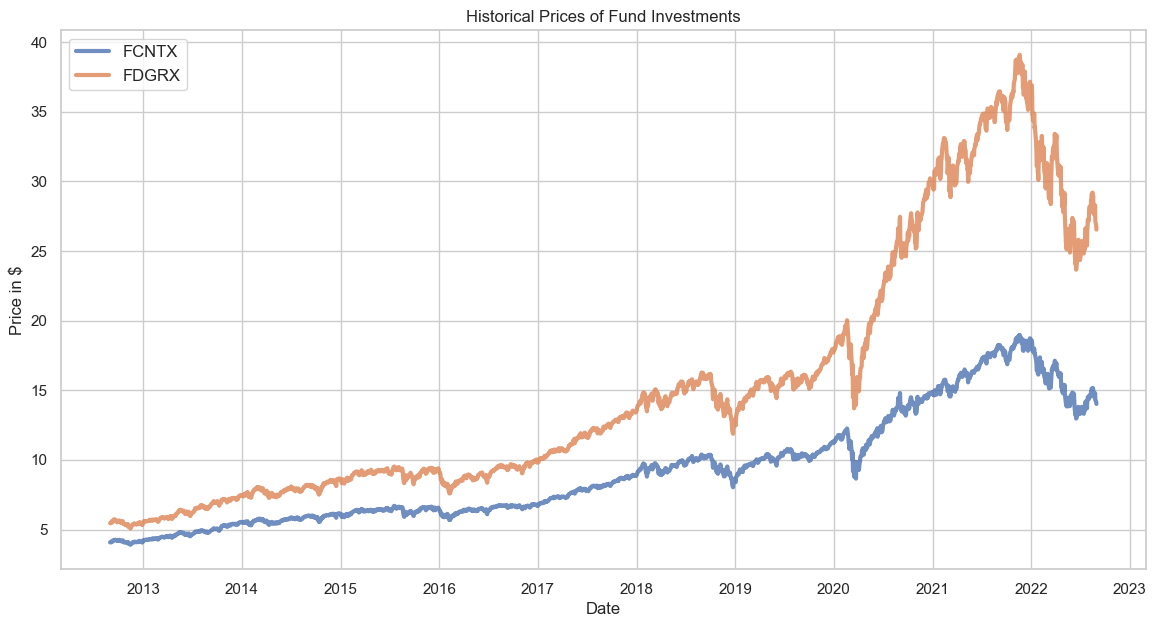

In [64]:
generate_asset_plot([large_df2])

Competitors
* https://www.betterment.com/advisors/401k
* risky/conserver slider doesn't give u much control, doesn't unlock high-vol strategies and refined control for the financially saavy individuals
* Although there are large financial advisors and roboadvisors in the market, this finance tool is easier to use, saves the hassle and money of becoming a customer to another institution, and allows users to take more customized control of their money.

TODO
* calculate any point on the frontier curve
    * TODO: calculate portfolio points on the frontier line but not on the 2 critical points for someone who wants more diversification/less risk with still as high but slightly less returns
* backtest
* do i consider that people continuously add to their 401k and multiple time points
    * thus, we recommended updating elections every couple of months/years to update prediction model and current best portfolio allocations
* prediction models (lstm, time-series)
    * wavlets--aryan shafqat used CQT for EKG data, but stocks don't have periods, but maybe first derivatives do. Look at period of changes in jumps in stock prices--expecting a jump in value on a quarterly basis--ricket wavlet or just overload with Fast fourier Transforms (ffts)
* writeup of plain-text recommendations/standard 401k education
    * market analysis/trends like inflation, interest rates, commodies, etc.
* small UI
    * dashboard that displays user input parameter selections, model ouptus, auxiliary market trends, hardcoded recs
    * params: age/expected years in market, risk profile, investment amount, fav sector for personal industry likes
    * explain what each mutual fund is, small cap vs large cap
* more EDA graphs
* presentation/video